# Operations with matrix product operators

## Create the MPO we want

In [242]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
import qutip as qt
import matplotlib.pyplot as plt
import copy
from sympy import expand
from matplotlib import cbook
import psutil
import time

In [243]:
# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of np.ndarray: MPO tensors for H0.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = g * sigma_z
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [244]:
# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x.

    Args:
        N (int): Number of qubits.

    Returns:
        list of np.ndarray: MPO tensors for Hc.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=object)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [245]:
def create_I_mpo(N):

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=object)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo
        

## Define the functions to operate (sum, product)

In [246]:
def add(mpo1,mpo2):

    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=object))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=object))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=object))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the tensors in the middle
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo

In [247]:
def prod_scalar(mpo, c):
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo

In [248]:
def prod(mpo1,mpo2):
    
    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=object))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=object))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=object))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[1]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo

In [249]:
def commutator(mpo1,mpo2):
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))

In [250]:
def trace_mpo(mpo1):

    mat = []

     ## First we add the empty first boundary to the new list of core tensors
    mat.append(np.zeros((1,mpo1[0].shape[1]), dtype=object))

     ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            mat.append(np.zeros((mpo1[i].shape[0],mpo1[i].shape[1]), dtype=object))

    ## Add the last ending boundary of the list of tensors
    mat.append(np.zeros((mpo1[len(mpo1)-1].shape[0],1), dtype=object))

    for i in range(2):
        for j in range(mpo1[0].shape[1]):
            mat[0][0,j] = mat[0][0,j] + mpo1[0][0,j,i,i]

    for i in range(2):
        for j in range(mpo1[len(mpo1)-1].shape[0]):
            mat[len(mpo1)-1][j,0] = mat[len(mpo1)-1][j,0] + mpo1[len(mpo1)-1][j,0,i,i]

    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(0,2):
                for k in range(mpo1[i].shape[0]):
                    for l in range(mpo1[i].shape[1]): 
                        mat[i][k,l] = mat[i][k,l] + mpo1[i][k,l,j,j]
                        

    ## Now contract the list of matrices, which are the previous tensors without the physical index, to get a single scalar
    result = mat[0].copy()
    for i in range(1, len(mat)):
        result = result @ mat[i]
        
    trace = result.item()

    
    return trace

## From MPO to full matrix

In [251]:
def contract(mpo):
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=object))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            for j in range(mpo[n].shape[1]):
                mpo_comp += np.kron((mpo_contracted[n])[0,j,:,:],(mpo[n+1])[j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]

In [252]:
def commute(M1,M2):
    return (M1 @ M2) - (M2 @ M1) 

## Bond reduction of the tensors

In [253]:
def reduce(mpo, bond_dimension):

    new_mpo = []
    return new_mpo

## Magnus and Chebyshev approximations for evolution

In [254]:
def Magnus_mpo(mpo_H0,mpo_Hc,u,x,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 

    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))

    M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
    
    M = add(M1,M2)

    return M

In [255]:
def Magnus(H0,Hc,u,x,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """
    def commute(M1,M2):
        return (M1 @ M2) - (M2 @ M1)

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 

    M1 = (a*H0) + (b*Hc)

    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))

    M2 = c*commute(H0,Hc)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
    
    M = M1 + M2

    return M

In [256]:
def Magnus_transpose(H0,Hc,u,x,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """
    def commute(M1,M2):
        return (M1 @ M2) - (M2 @ M1)

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 

    M1 = (a*H0) + (b*Hc)

    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))

    M2 = c*commute(H0,Hc)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
    
    M = -M1 - M2

    return M

In [257]:
def Chebyshev_mpo(mpo,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)
    C3 = prod_scalar(prod(mpo,mpo),c)

    C = add(C1,C2)

    
    return C

In [258]:
def Chebyshev(M,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = a*np.eye(M.shape[0])
    C2 = b*M
    C3 = (c*M) @ M

    C = C1+C2

    
    return C

In [259]:
def Magnus_mpo_transpose(mpo_H0,mpo_Hc,u,x,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1,x), (t1, 0, T)) 

    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    c = -1/2 * sp.integrate(sp.integrate(u(t2,x)-u(t1,x),(t2,0,t1)),(t1,0,T))

    M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3,x)-2*u(t2,x)+u(t1,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1,x)*u(t3,x)-u(t1,x)*u(t2,x)-u(t2,x)*u(t3,x),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
    
    M = add(prod_scalar(M1,-1),prod_scalar(M2,-1))

    return M

## Exact evolution

In [260]:
def get_unitary(H0, Hc, x, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
    - H0: numpy array, static Hamiltonian
    - Hc: numpy array, control Hamiltonian
    - u: function u(t) defining time dependence
    - T: float, total evolution time
    - timesteps: int, number of time steps for integration

    Returns:
    - U_T: numpy array, final unitary matrix at time T
    """
    def u(t, args):
        x = args['x']  # Retrieve control parameters correctly from args
        return x[0] + x[1] * t + x[2] * t**2
    
    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0)
    Hc_q = qt.Qobj(Hc)

    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qeye(H0.shape[0])
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)

    # Solve Schrödinger equation
    result = qt.sesolve(H, qt.qeye(H0.shape[0]), tlist, args={'x': x})

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T

In [261]:
def log(U):
    
    eigvals, eigvecs = np.linalg.eig(U)

    log_eigvals = np.diag(np.log(eigvals))

    # Reconstruct the logarithm of the matrix
    log_U = eigvecs @ log_eigvals @ np.linalg.inv(eigvecs)
    
    return log_U

In [262]:
def err_fidelity(U,V):

    ## Computes the fidelity error: 1-fidelity

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return np.abs(1 - fidelity)

In [263]:
def square_frob(A):
    return sum(sp.re(np.conjugate(z) * z) for row in A for z in row)

In [264]:
def full_compare(N,g,T):

    ## Compare (error) the exact solution to the MPO solution with Magnus and M+C
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/np.linalg.norm(contract(create_H0_mpo(N,g))))
    mpo2 = prod_scalar(create_Hc_mpo(N),1/np.linalg.norm(contract(create_Hc_mpo(N))))
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    Err1 = err_fidelity(U_exact,expm(contract(Mag)))
    Err2 = err_fidelity(U_exact,contract(U_computed))
    Err3 = np.linalg.norm(U_exact-expm(contract(Mag)))
    Err4 = np.linalg.norm(U_exact-contract(U_computed))

    return Err1, Err2, Err3, Err4

In [295]:
def compare_time_mem(N,g,T,u):

    ## Compare the time and memory it takes to compute with mpo and without

    process = psutil.Process()

    mem_before = process.memory_info().rss / (1024**2)
    start_mpo = time.time()
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/2**N)
    mpo2 = prod_scalar(create_Hc_mpo(N),1/2**N)
    Mag = Magnus_mpo(mpo1,mpo2,u,x, T)
    MagT = Magnus_mpo_transpose(mpo1,mpo2,u,x, T)
    J = add(create_Hc_mpo(N),prod_scalar(create_Hc_mpo(N),-np.pi/2))
    Obj_mpo = trace_mpo(prod(add(MagT,prod_scalar(J,1j)),add(Mag,prod_scalar(J,-1j))))
    time_mpo = time.time() - start_mpo
    mem_after = process.memory_info().rss / (1024**2)
    mem_mpo = mem_after - mem_before

    mem_before = process.memory_info().rss / (1024**2)
    start_exact = time.time()
    H0 = contract(mpo1)
    Hc = contract(mpo2)
    Mag = Magnus(H0,Hc,u,x, T)
    MagT = Magnus_transpose(H0,Hc,u,x, T)
    J_dense = contract(J)
    Obj_dense = np.trace((MagT+1j*J_dense)@(Mag-1j*J_dense))
    time_exact = time.time() - start_exact
    mem_after = process.memory_info().rss / (1024**2)
    mem_exact = mem_after - mem_before

    return time_exact, time_mpo, mem_exact, mem_mpo

In [266]:
def compare(N,g,T):

    ## Compare (error) the exact solution to the MPO solution with Magnus and M+C
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/np.linalg.norm(contract(create_H0_mpo(N,g))))
    mpo2 = prod_scalar(create_Hc_mpo(N),1/np.linalg.norm(contract(create_Hc_mpo(N))))
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    Err = err_fidelity(U_exact,contract(U_computed))

    return Err

## Example trial

In [267]:
x1, x2, x3 = sp.symbols('x1 x2 x3')
x = [x1,x2,x3]

def u2(t,x):
    return x[0] + x[1]*t + x[2]*t**2

N1 = 7
g1 = 1
T1 = 0.1

In [268]:
mpo11 = create_H0_mpo(N1,g1)
mpo21 = create_Hc_mpo(N1)
H0 = contract(mpo11)
Hc = contract(mpo21)

In [269]:
Mag = Magnus_mpo(mpo11,mpo21,u2,x,T1)
MagT = Magnus_mpo_transpose(mpo11,mpo21,u2,x,T1)

In [270]:
J = add(create_Hc_mpo(N1),prod_scalar(create_Hc_mpo(N1),-np.pi/2))

In [271]:
U_exact = expm(contract(J))

In [272]:
Obj_mpo = trace_mpo(prod(add(MagT,prod_scalar(J,1j)),add(Mag,prod_scalar(J,-1j))))

In [273]:
Obj_mpo = expand(Obj_mpo)

In [274]:
Obj_dense = np.trace((contract(MagT)+1j*contract(J))@(contract(Mag)-1j*contract(J)))

In [275]:
Obj_dense = expand(Obj_dense)

In [276]:
Obj_mpo

8.96*x1**2 + 0.896*x1*x2 + 0.0597333333333333*x1*x3 - 102.286701761645*x1 + 0.0224248888888889*x2**2 + 0.00299164444444445*x2*x3 - 5.11433508808227*x2 + 9.98044444444445e-5*x3**2 - 0.340955672538818*x3 + 300.884368227562

In [277]:
Obj_dense

8.96*x1**2 + 0.896*x1*x2 + 0.0597333333333333*x1*x3 - 102.286701761645*x1 + 0.0224248888888889*x2**2 + 0.00299164444444445*x2*x3 - 3.97046694025453e-23*I*x2*x3 - 5.11433508808227*x2 + 9.98044444444445e-5*x3**2 - 0.340955672538818*x3 + 300.884368227561

In [278]:
import json

def sympy_to_julia(expr):
    """Convert a SymPy expression to a Julia-compatible string."""
    if isinstance(expr, sp.core.numbers.ImaginaryUnit):
        # Handle imaginary unit (I -> im)
        return "im"
    elif expr.is_Number:
        # Handle numbers (integers, floats, etc.)
        if isinstance(expr, sp.Float):
            return f"{float(expr):.16e}"  # Convert to Julia-compatible float
        elif isinstance(expr, sp.Integer):
            return str(int(expr))
        else:
            return str(expr)
    elif expr.is_Symbol:
        # Handle symbols (e.g., x, y)
        return str(expr)
    elif expr.is_Add:
        # Handle addition: Add(a, b) -> a + b
        return " + ".join([sympy_to_julia(arg) for arg in expr.args])
    elif expr.is_Mul:
        # Handle multiplication: Mul(a, b) -> a * b
        parts = []
        for arg in expr.args:
            if isinstance(arg, sp.core.numbers.NegativeOne):
                parts.append("-")
            else:
                parts.append(f"({sympy_to_julia(arg)})")
        return " * ".join(parts)
    elif expr.is_Pow:
        # Handle exponents: Pow(a, b) -> a^b
        base = sympy_to_julia(expr.args[0])
        exponent = sympy_to_julia(expr.args[1])
        return f"{base}^{exponent}"
    else:
        raise NotImplementedError(f"Unsupported SymPy expression: {expr.func}")

julia_poly = sympy_to_julia(Obj_dense)

# Save to JSON
with open('polynomial_dense.json', 'w') as f:
    json.dump(julia_poly, f, indent=4)

In [279]:
import json


def sympy_to_julia(expr):
    """Convert a SymPy expression to a Julia-compatible string while preserving structure."""
    
    if isinstance(expr, sp.core.numbers.ImaginaryUnit):
        return "im"  # Convert imaginary unit
    elif expr.is_Number:
        return str(expr)  # Keep numbers unchanged
    elif expr.is_Symbol:
        return str(expr)  # Keep symbols unchanged
    elif expr.is_Add:
        return " + ".join(sympy_to_julia(arg) for arg in expr.args)
    elif expr.is_Mul:
        parts = []
        for arg in expr.args:
            if arg == -1:
                parts.append("-")  # Handle negative numbers correctly
            else:
                parts.append(sympy_to_julia(arg))
        return " * ".join(parts)
    elif expr.is_Pow:
        base, exponent = expr.args
        return f"{sympy_to_julia(base)}^{sympy_to_julia(exponent)}"  # No unnecessary parentheses
    else:
        raise NotImplementedError(f"Unsupported SymPy expression: {expr}")

julia_poly = sympy_to_julia(Obj_mpo)

# Save to JSON
with open('polynomial_mpo.json', 'w') as f:
    json.dump(julia_poly, f, indent=4)

In [280]:
U_approx_dense = get_unitary(H0,Hc,[478.65933841838154,
 -28377.075229414113,
 283770.7162108846],T1)

In [281]:
err_fidelity(U_exact, U_approx_dense)

0.6146220738173873

In [282]:
U_approx_mpo = get_unitary(H0,Hc,[-158.52183168224707,
   9853.827384811297,
 -98538.47224676146],T1)

In [283]:
err_fidelity(U_exact, U_approx_mpo)

0.5950546411977811

## Plots

In [312]:
x1, x2, x3 = sp.symbols('x1 x2 x3')
x = [x1,x2,x3]

def u(t,x):
    return x[0] + x[1]*t + x[2]*t**2

N = 9
g = 1
T = 0.1

In [313]:
time_dense = []
mem_dense = []
time_mpo = []
mem_mpo = []

for i in range(2,N+1):
    print(i)
    time1, time2, mem1, mem2 = compare_time_mem(i,g,T,u)
    
    time_dense.append(time1)
    mem_dense.append(mem1)
    time_mpo.append(time2)
    mem_mpo.append(mem2)

In [314]:
time_dense

[0.30487871170043945,
 0.31637001037597656,
 0.391282320022583,
 0.7251627445220947,
 2.418672561645508,
 11.667222738265991,
 80.6086254119873,
 490.2688627243042]

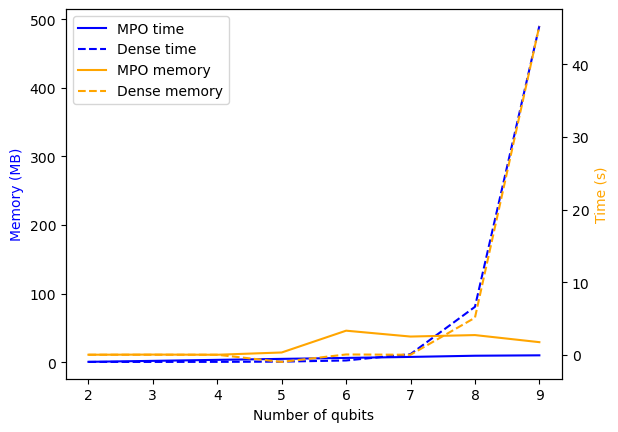

In [316]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax1 = plt.subplots()

# Create secondary y-axis
ax2 = ax1.twinx()
#for j in range(reps):
    # Plot memory usage
    #ax1.plot(range(2, N+1), memory_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="blue")  # Solid blue for MPO
    
    # Plot time usage
    #ax2.plot(range(2, N+1), time_mpo[j],linestyle="--", linewidth=1, alpha=0.2, color="orange")  # Solid blue for MPO
    
# Plot time usage
ax1.plot(range(2, N+1), time_mpo, 'b-', label="MPO time")  # Solid blue for MPO
ax2.plot(range(2, N+1), mem_mpo,'orange', linestyle='-', label="MPO memory")  # Solid blue for MPO


# Plot time usage
ax1.plot(range(2, N+1), time_dense, 'b--', label="Dense time")  # Solid blue for MPO
ax2.plot(range(2, N+1), mem_dense,'orange', linestyle='--', label="Dense memory")  # Solid blue for MPO

# Labels and colors
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Memory (MB)', color='blue')  # Blue for memory axis
ax2.set_ylabel('Time (s)', color='orange')  # Green for time axis

# Legends (need to combine both axes legends)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Save and show plot
plt.savefig("Time_memory_control_mpo (2,2)")
plt.show()

### Compare MPO evolution to exact

In [ ]:
N1 = 8
g1 = 1
T1 = 0.5

errs = []

for i in range(2,N1+1):
    errs.append(compare(i,g1,T1))

In [ ]:
plt.plot(range(2,N1+1),errs)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity between exact and MPO')

### Full comparison

In [ ]:
err_magnus = []
err_cheby = []
err_magnus1 = []
err_cheby1 = []

for i in range(2,N1+1):
    err1, err2, err3, err4 = full_compare(i,g1,T1)

    err_magnus.append(err1)
    err_cheby.append(err2)
    err_magnus1.append(err3)
    err_cheby1.append(err4)

In [ ]:
plt.plot(range(2,N1+1),err_magnus)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity of Magnus')

In [ ]:
plt.plot(range(2,N1+1),err_cheby)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity of Magnus and Chebyshev')

In [ ]:
plt.plot(range(2,N1+1),err_magnus1)
plt.xlabel('Number of qubits')
plt.ylabel("Norm error of Magnus")

In [ ]:
plt.plot(range(2,N1+1),err_cheby1)
plt.xlabel('Number of qubits')
plt.ylabel('Norm error Magnus and Chebyshev')